In [1]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, f1_score, roc_auc_score,roc_curve, accuracy_score, precision_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.read_csv('cleaned_data.csv')

In [2]:
def execute_fit_predict(classifier_model, X_train, y_train, X_test):
    classifier_model.fit(X_train, y_train)
    pred = classifier_model.predict(X_test)
    return pred

In [3]:
def execute_evaluate(y_test, pred=None, pred_proba=None):
    # get confusion matrix
    confusion = confusion_matrix( y_test, pred)
    # get accuracy score
    accuracy = accuracy_score(y_test , pred)
    # get precision
    precision = precision_score(y_test , pred)
    # get recall
    recall = recall_score(y_test , pred)
    # get f1 score
    f1 = f1_score(y_test,pred)
    # get auc score
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    result = {
        "roc_auc": [roc_auc.round(4)],
        "precision": [precision.round(4)],
        "recol": [recall.round(4)],
        "f1": [f1.round(4)],
        "accuracy": [accuracy.round(4)],
    }

    return (confusion,pd.DataFrame(result))


In [4]:
def execute_cross_validation(classifier_model, X_features, y_targets, folds):
    kfold = KFold(n_splits=folds)
    scores = []
    for i , (train_index, test_index) in enumerate(kfold.split(X_features)):
        # Create index pointing to training and validation data by cross-validation from the data
        X_train, X_test = X_features.values[train_index], X_features.values[test_index]
        y_train, y_test = y_targets.values[train_index], y_targets.values[test_index]
        
        # train and fit
        pred = execute_fit_predict(classifier_model=classifier_model, X_train=X_train, y_train=y_train, X_test=X_test)
        pred_proba = classifier_model.predict_proba(X_test)[:,1]
        score = execute_evaluate(y_test=y_test, pred=pred, pred_proba=pred_proba)
        scores.append({"index":i, "score":score })
    return sorted(scores, key=lambda x: x['score'][1]['roc_auc'].iloc[0], reverse=True)



In [5]:
def roc_curve_plot(y_test ,X_test, classifier_models=None, labels=[""], title=""):
    fig, _ = plt.subplots(constrained_layout=True, figsize=(4, 4))
    fig.suptitle(title, fontsize=12)
    for idx, classifier_model in enumerate(classifier_models):
        y_pred_proba = classifier_model.predict_proba(X_test)[:,1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc = roc_auc_score(y_test, y_pred_proba)
        plt.plot(fpr, tpr, 'o-', ms=1, label="{} auc={}".format(labels[idx],auc ))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend(loc=4)
    plt.title('ROC Curve')    
    plt.show()

In [6]:
def evaluate_heatmap(evaluation, fig_title=""):
    fig, axs = plt.subplots(figsize=(6, 3), ncols=2, constrained_layout=True )
    fig.suptitle(fig_title, fontsize=12)
    axs[1].title.set_text("Counfusion_Matrix")
    axs[0].title.set_text("SCORE")
    for i in enumerate(evaluation):
        sns.heatmap(evaluation[1], cmap="YlGnBu", annot=True, ax=axs[0], cbar=False)
        sns.heatmap(evaluation[0], annot=True, ax=axs[1], cbar=False)

# Decision Tree
## Without cross validation vs With cross validation

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


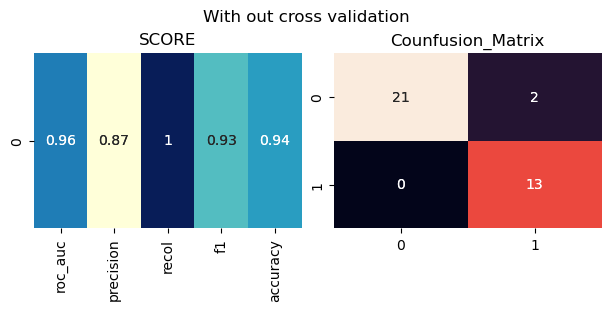

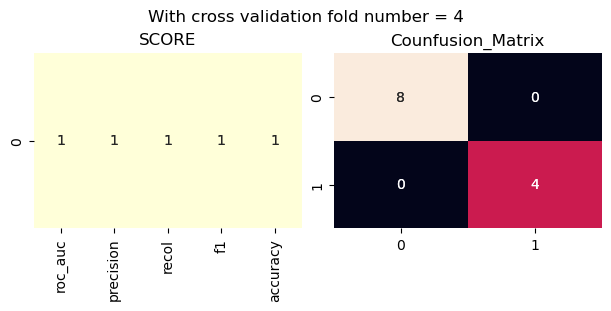

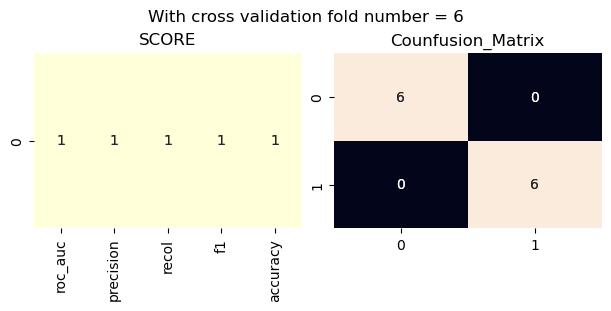

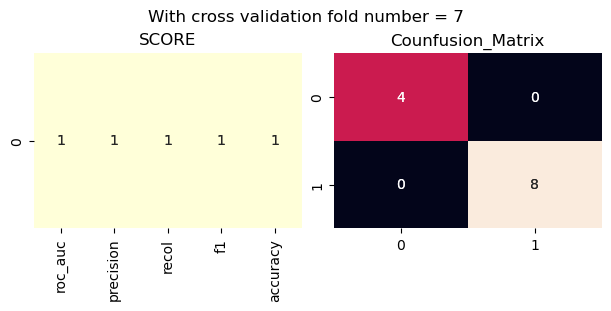

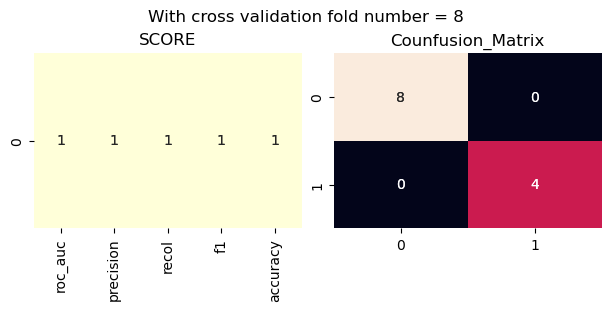

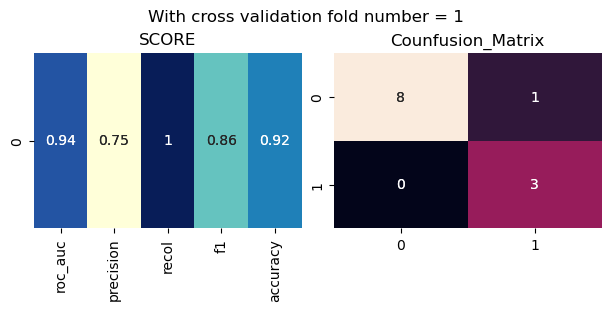

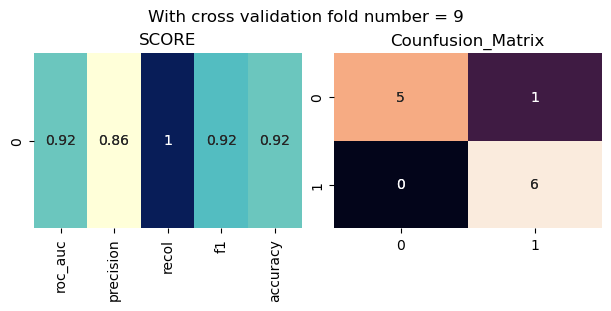

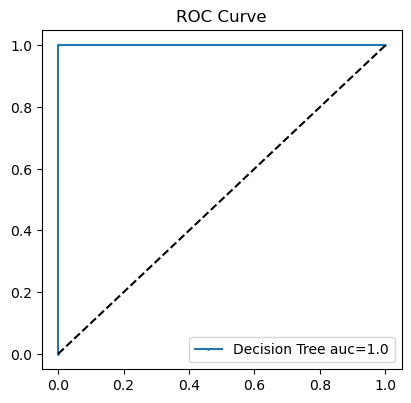

In [7]:
X_features = df.drop(['Fraud'], axis=1)
y_targets = df['Fraud']
X_train, X_test, y_train, y_test=train_test_split(X_features, y_targets, test_size=0.3)

decision_tree = DecisionTreeClassifier()
pred = execute_fit_predict(classifier_model=decision_tree, X_train=X_train, y_train=y_train, X_test=X_test)
pred_proba = decision_tree.predict_proba(X_test)[:,1]
evaluation = execute_evaluate(y_test=y_test,pred=pred,pred_proba=pred_proba)
evaluate_heatmap(evaluation=evaluation, fig_title="With out cross validation")
cross_validation_scores = execute_cross_validation(classifier_model=decision_tree, X_features=X_features, y_targets=y_targets, folds=10)

for idx, x in enumerate(cross_validation_scores):
    if(idx > 5):break
    evaluate_heatmap(x['score'], fig_title="With cross validation fold number = {}".format(x['index']))

roc_curve_plot(y_test=y_test, X_test=X_test, classifier_models=[decision_tree],labels=["Decision Tree"])

# cross_val_score_API = cross_val_score(decision_tree, X_features, y_targets, scoring = 'roc_auc', cv=10)
# print(cross_val_score_API)


# Random Forest
## Without cross validation vs With cross validation

/opt/conda/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


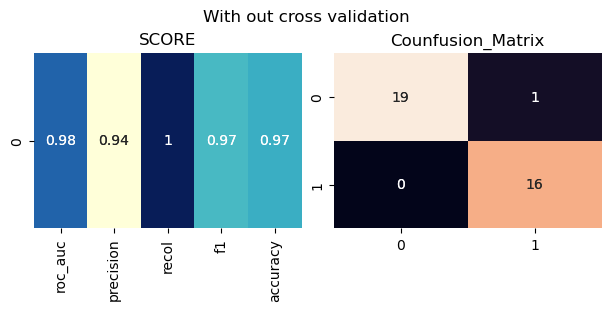

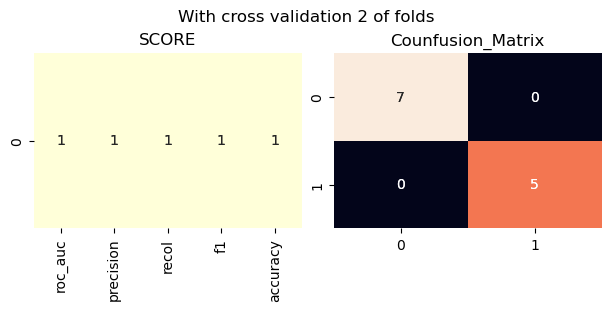

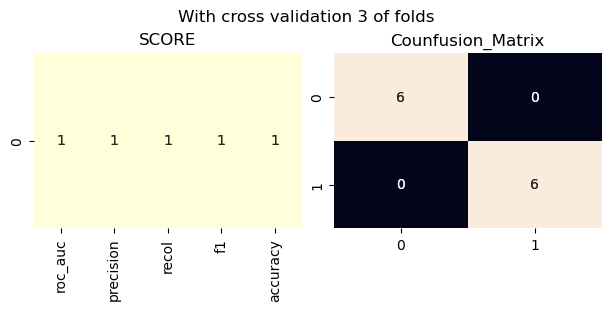

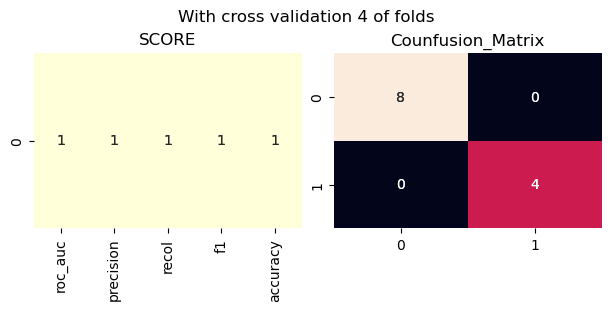

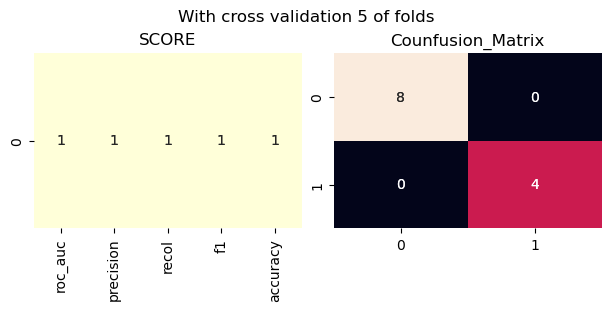

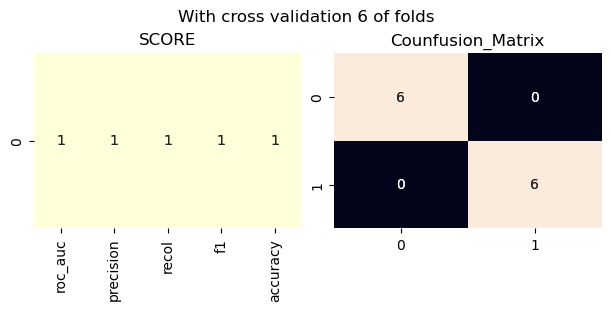

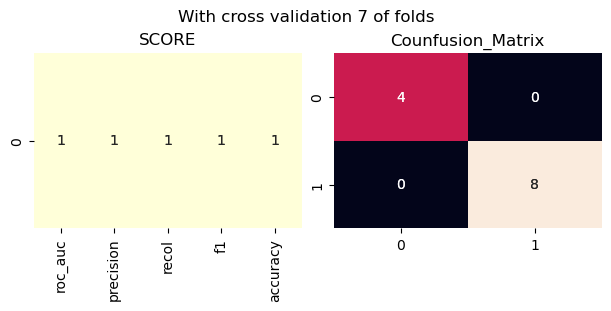

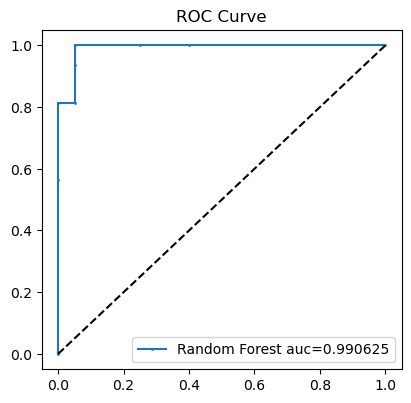

In [8]:
X_features = df.drop(['Fraud'], axis=1)
y_targets = df['Fraud']
X_train, X_test, y_train, y_test=train_test_split(X_features, y_targets, test_size=0.3)

random_forest = RandomForestClassifier()
pred = execute_fit_predict(classifier_model=random_forest, X_train=X_train, y_train=y_train, X_test=X_test)
pred_proba = random_forest.predict_proba(X_test)[:,1]
evaluation = execute_evaluate(y_test=y_test,pred=pred,pred_proba=pred_proba)
evaluate_heatmap(evaluation, fig_title="With out cross validation")
cross_validation_scores = execute_cross_validation(classifier_model=random_forest, X_features=X_features, y_targets=y_targets, folds=10)
for idx, x in enumerate(cross_validation_scores):
    if(idx > 5):break
    evaluate_heatmap(x['score'], fig_title="With cross validation {} of folds".format(x['index']))

roc_curve_plot(y_test=y_test, X_test=X_test, classifier_models=[random_forest],labels=["Random Forest"])



# Vusualise roc_curve

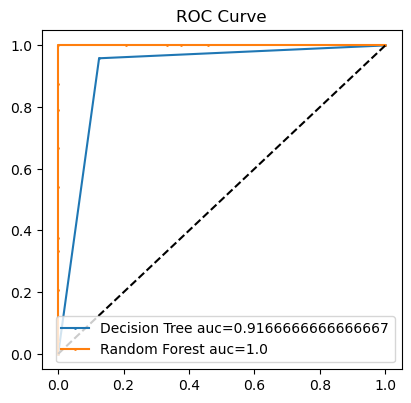

In [9]:
X_features = df.drop(['Fraud'], axis=1)
y_targets = df['Fraud']
X_train, X_test, y_train, y_test=train_test_split(X_features, y_targets, test_size=0.4)

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

roc_curve_plot(y_test=y_test, X_test=X_test, classifier_models=[decision_tree, random_forest],labels=["Decision Tree","Random Forest"])



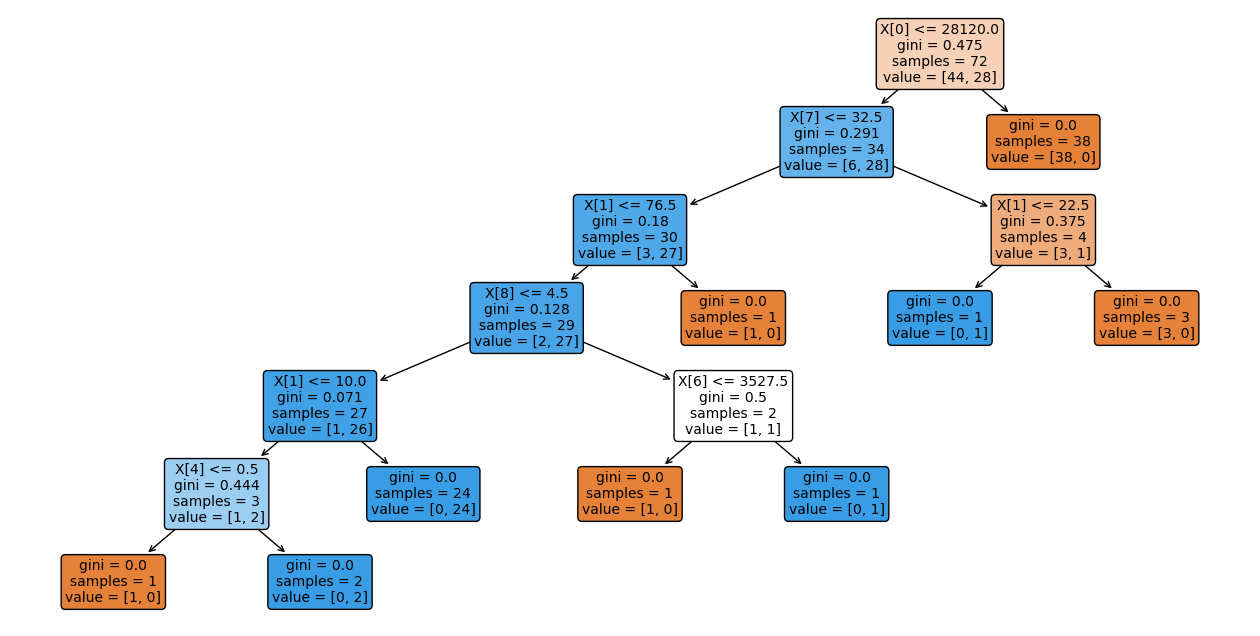

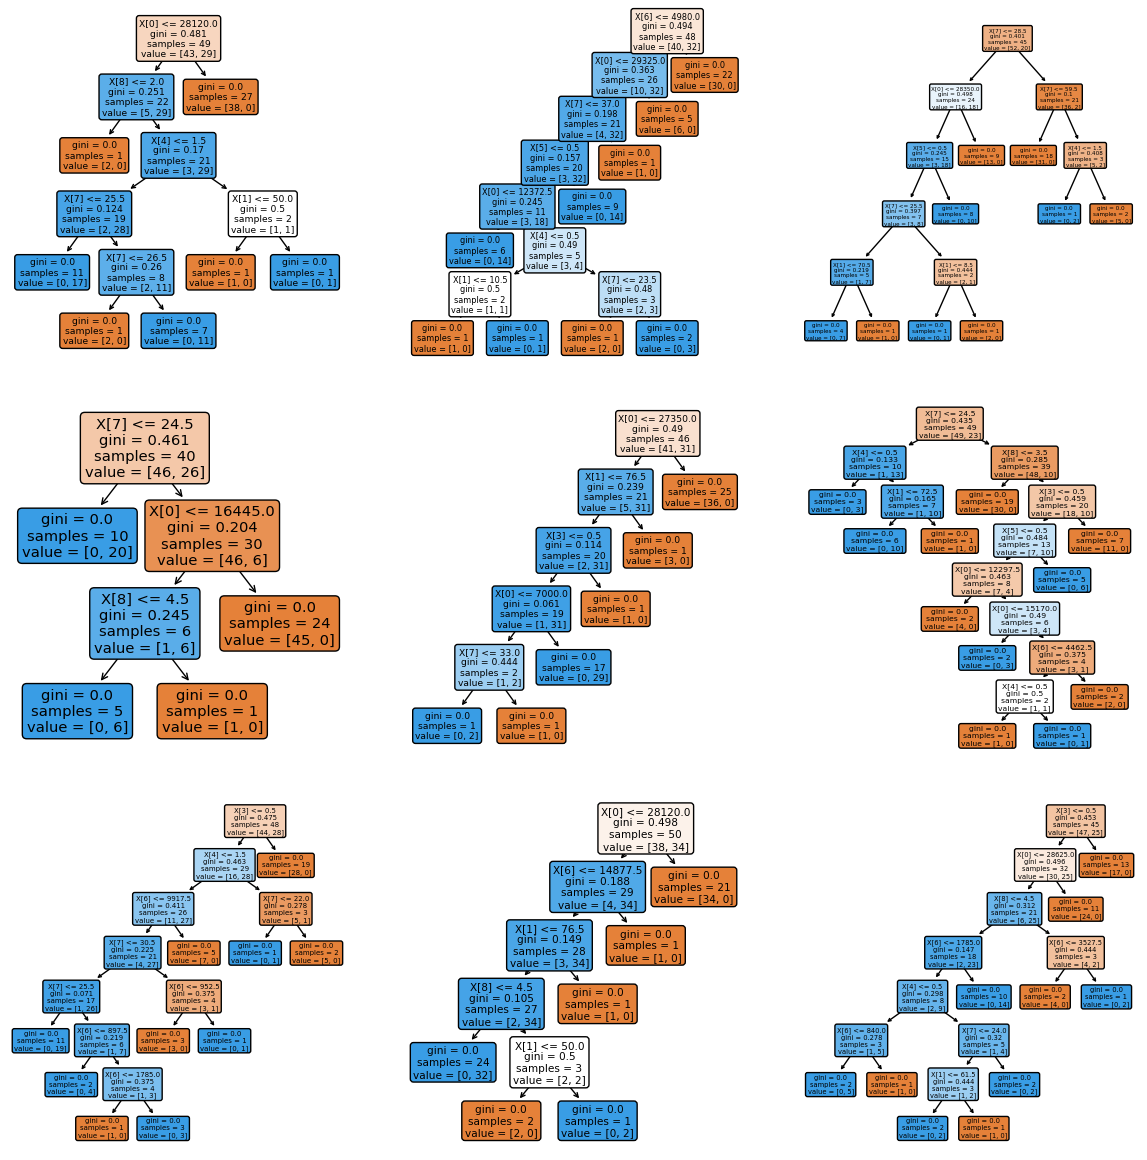

In [10]:
fig, ax = plt.subplots(figsize=(16, 8))
plot_tree(decision_tree, fontsize=10, filled=True, impurity=True,rounded=True)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12), nrows=3, ncols=3)
fig.tight_layout()
for i, model in enumerate(random_forest.estimators_):
    if i > 8:break
    row = int(i/3)
    col = i%3
    plot_tree(random_forest.estimators_[i], filled=True, impurity=True,rounded=True, ax=ax[row][col])
plt.show()
